In [1]:
from fastai.vision.all import *
import timm
from dice import DiceLoss
import segmentation_models_pytorch as smp

In [2]:
path = Path('/home/ubuntu/data/seg/bin')
get_msk = lambda o: path/'masks'/f'{o.stem}{o.suffix}'

In [3]:
path_im = path/'train'
path_lbl = path/'masks'

In [4]:
bin_seg = DataBlock(blocks=(ImageBlock(), MaskBlock([0, 1])),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

In [5]:
dls = bin_seg.dataloaders(path_im, bs=64).cuda()

/home/ubuntu/anaconda3/envs/torchdl0/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/ubuntu/anaconda3/envs/torchdl0/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpa

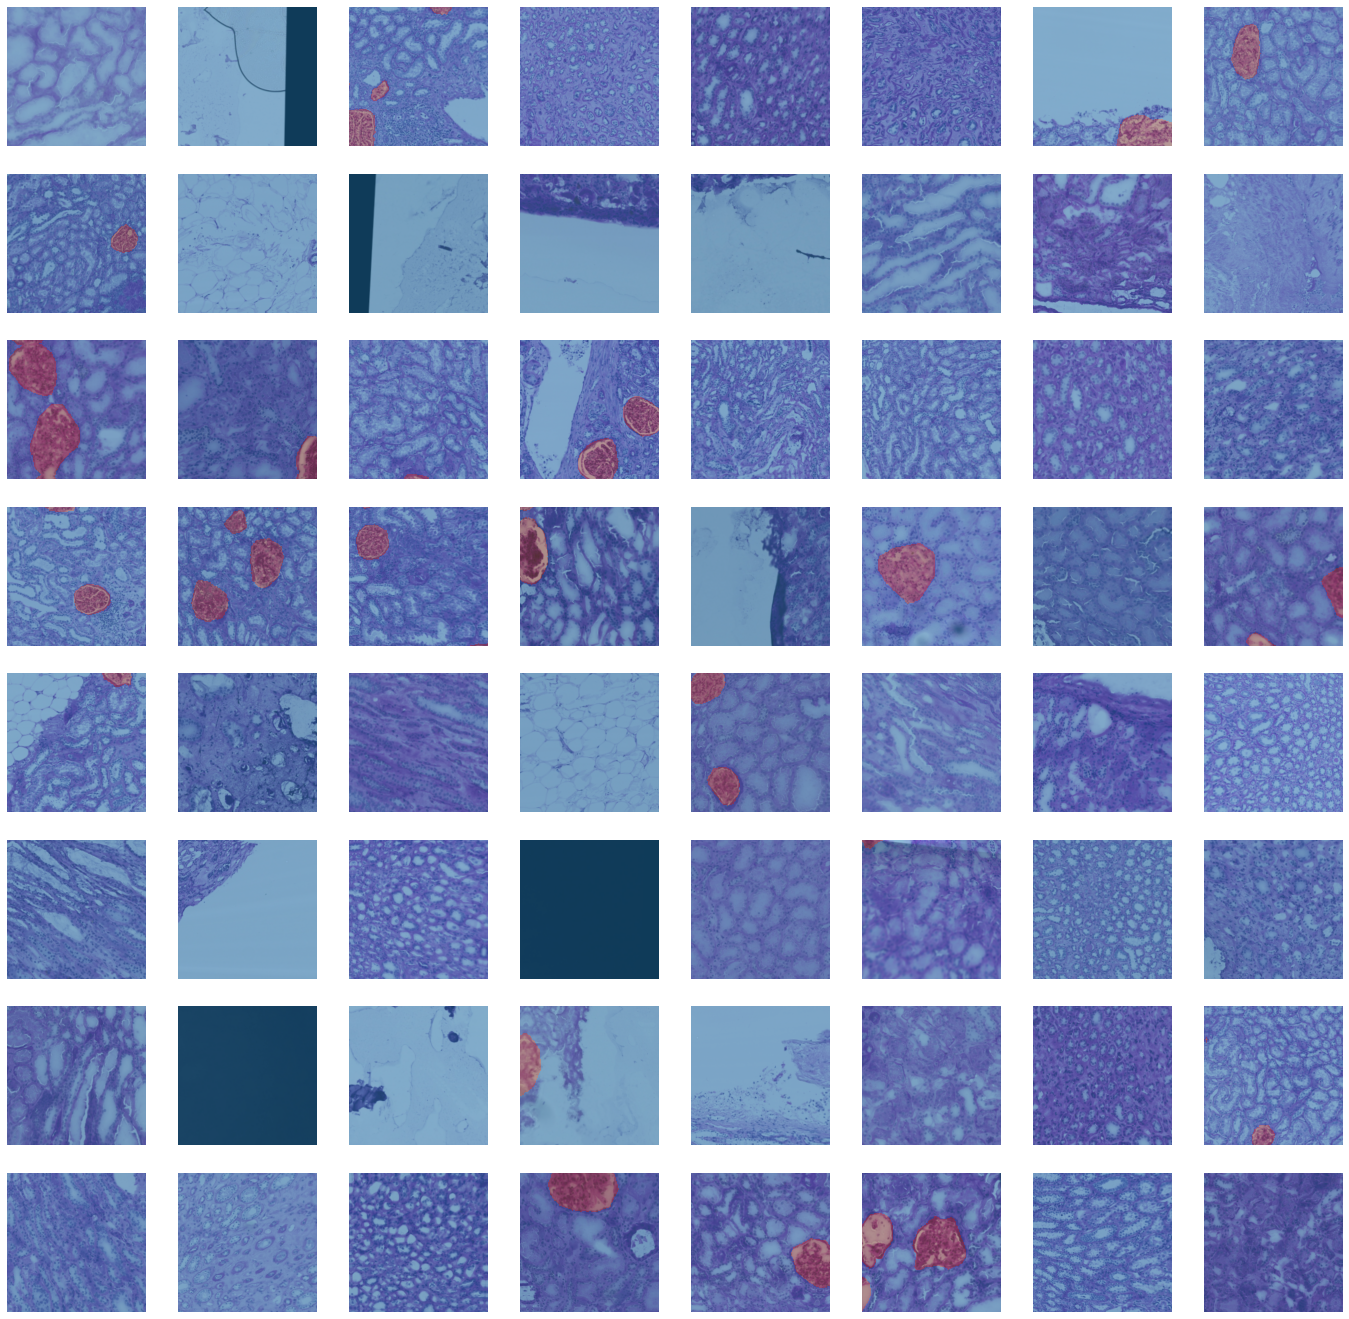

In [6]:
dls.show_batch(max_n=64)

In [7]:
model = smp.Unet(
    encoder_name="tu-resnet34d",        
    encoder_weights="imagenet",     
    in_channels=3,
    classes=1,
)

In [8]:
class Dice_soft(Metric):
    def __init__(self, axis=1): 
        self.axis = axis 
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()
    @property
    def value(self): return 2.0 * self.inter/self.union if self.union > 0 else None

In [9]:
unet_splitter = lambda m: L(m.encoder, nn.Sequential(m.decoder, m.segmentation_head)).map(params)
learn = Learner(dls, model, 
                loss_func = DiceLoss(mode="binary", log_loss=True), 
                splitter=unet_splitter, 
                cbs = [TerminateOnNaNCallback()],
                metrics=[Dice_soft()]).to_fp16()
learn.freeze()

In [10]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,dice_soft,time
0,0.763998,0.195493,0.825257,01:16
1,0.231905,0.220767,0.807333,01:07
2,0.151686,0.116350,0.892194,01:06
3,0.135771,0.110928,0.896297,01:06


/home/ubuntu/anaconda3/envs/torchdl0/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
learn.unfreeze()
learn.fit_one_cycle(16, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,dice_soft,time
0,0.130958,0.115808,0.892101,01:15
1,0.123564,0.104304,0.903006,01:16
2,0.116577,0.114361,0.893822,01:14
3,0.109979,0.096653,0.909024,01:14
4,0.097358,0.102664,0.904377,01:14
5,0.092124,0.099008,0.908324,01:16
6,0.092547,0.093025,0.913842,01:14
7,0.083140,0.087439,0.918261,01:14
8,0.084941,0.081744,0.922678,01:14
9,0.080701,0.092108,0.914807,01:16


In [24]:
def create_segmentation_model(backbone: str = 'resnet34', arch: str = 'unet', classes: int = 1):
    model_dict = model_dict = {'unet': smp.Unet,
              'unet++': smp.UnetPlusPlus,
              'manet': smp.MAnet,
              'linknet': smp.Linknet,
              'fpn': smp.FPN,
              'pspnet': smp.PSPNet,
              'PAN': smp.PAN,
              'deeplabv3': smp.DeepLabV3,
              'deeplabv3+': smp.DeepLabV3Plus}
    return model_dict[arch](encoder_name = 'tu-' + backbone,
                            encoder_weights='imagenet',
                            in_channels=3, classes=classes)

In [2]:
with open('/home/ubuntu/data/seg/segm/classes.txt', 'r') as f:
    o = f.read()

In [4]:
o.split('\n')

['class0', 'class1', 'class2', 'class3', 'class4']

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
x = np.linspace(0, 1, 100)
y = x/(2-x)

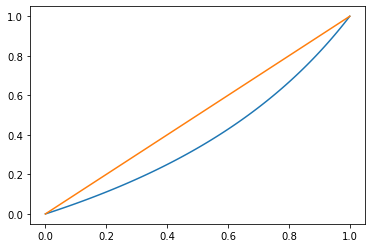

In [11]:
plt.plot(x, y, x, x)

In [10]:
0.8/1.2

0.6666666666666667